# Проект для «Викишоп»

**Введение**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Описание данные**

Данные находятся в файле `/datasets/toxic_comments.csv`. Столбец `text` в нём содержит текст комментария, а `toxic` — целевой признак

**Ход работы**

1. Загрузка и подготовка данных
2. Обучение разных моделей
3. Вывод

## Загрузка и подготовка данных

### Загрузка и анализ данных

Подключим необходимые библиотеки.

In [3]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))

from sklearn.utils import resample, shuffle

import spacy
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, f1_score

from warnings import filterwarnings
filterwarnings('ignore')

RANDOM_STATE = 12345

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anatoly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


|Произведем выгрузку данных в переменную `data`.

In [4]:
try:
    data = pd.read_csv('toxic_comments.csv')
except FileExistsError:
    data = pd.read_csv('/datasets/toxic_comments.csv')

data.head(5)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Изучим данные.

In [5]:
print(
    data.info(),
    f'\n\nКоличество дубликатов: {data.duplicated().sum()}')

print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
None 

Количество дубликатов: 0



Посмотрим на наличие неявных аномалий, а точнее - присутствие других языков в сообщениях.

**Промежуточный вывод:**

* Пропуски отсутствуют
* Дубликаты отсутствуют
* Типы данных в столбцах - корректны
* Присутствует лишний столбец - `Unnamed: 0`


Удалим столбец `Unnamed: 0`

In [6]:
data = data.drop('Unnamed: 0', axis = 1)

### Подготовка данных

Перед тем как обучать разные модели необходимо провести `предобработку текста`.


Выполним следующие пункты:


1. Проверим баланс классов
2. Очистка текстов с помощью регулярных выражений.
3. Удаление слов с помощью стоп-слов.
4. Лемматизация.

Проверим баланс классов. Напишем функцию для отрисовки круговой диаграммы классов `pie_class`.

In [7]:
def pie_class(data_class):
    plt.figure(figsize=(12, 5))
    colors = sns.color_palette('pastel')[0:5]

    plt.pie(data_class.value_counts(), colors=colors, labels=['non-toxic', 'toxic'], autopct='%.0f%%')
    plt.title('Balance of classes')

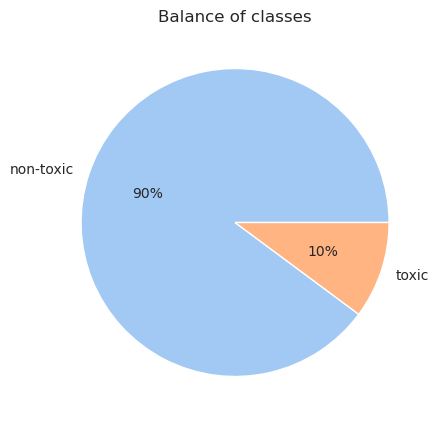

In [8]:
pie_class(data.toxic)

Присутствует сильный дисбаланс классов, поэтому выполним `Upsampling`. Решим эту проблему при разделении выборки.

Выполним пункты `2-4`. Напишем функцию `lemmatize_and_clear_data`.

In [11]:
def lemmatize_and_clear_data(data):
    text =  "".join(re.sub('[^a-zA-Z\']',
                           ' ',
                           data.text).lower()).split()

    words_filtered = []

    for w in text:
        if w not in stops:
            words_filtered.append(w)

    doc = nlp(" ".join(words_filtered))

    text_cl_and_lm = " ".join([token.lemma_ for token in doc]).lower()

    return text_cl_and_lm


In [12]:
tqdm.pandas()
data.text = data.progress_apply(lemmatize_and_clear_data, axis = 1)

100%|██████████| 159292/159292 [06:03<00:00, 437.64it/s]


Данные успешно очищены и лемматизированны.

### Векторизация текстов

Разделим данные на тренировочную и тествую выборки.

In [13]:
data_train, data_test = train_test_split(data, test_size=.2, random_state=RANDOM_STATE)

Так как у нас был обнаружен диссбаланс классов, выполним `up-sampling` для `data_train`. Напишем функцию up_sample.

In [14]:
def up_sample(data):
    toxic_upsample = resample(data.loc[data.toxic == 1],
                              replace=True,
                              n_samples=len(data.loc[data.toxic == 0]),
                              random_state=RANDOM_STATE)
    data = shuffle(
        pd.concat([toxic_upsample, data.loc[data.toxic == 0]])
    ).reset_index(drop = True)

    return data

In [16]:
data_train = up_sample(data_train)

Для определения тональности определим величины `TF-IDF` как признаки.

In [32]:
count_tf_idf = TfidfVectorizer()

features_data_train = count_tf_idf.fit_transform(data_train.text)
target_data_train = data_train.toxic

features_data_test = count_tf_idf.transform(data_test.text)
target_data_test = data_test.toxic

## Обучение разных моделей

Подберем наилучшие гиперпараметры для следующих моделей:

1. DecisionTreeClassifier
2. RandomForestClassifier
3. LogisticRegression
4. CatBoostClassifier

Создадим словари параметров для обучения моделей.

In [23]:
tree_params = {
    'max_depth': [2, 4, 6, 8],
    'criterion': ['gini', 'entropy']
}

forest_params = {
    'max_depth': [2, 4, 6, 8],
    'n_estimators': [25, 50, 85, 100],
    'criterion': ['gini', 'entropy']
}

logistic_params = {
    "C": np.logspace(-3,3,7),
    "penalty": ["l1","l2"]}

catboost_params = {
    'learning_rate': [0.03, 0.1],
    'depth': [2, 4, 6]
}

model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
model_forest = RandomForestClassifier(random_state=RANDOM_STATE)
model_logistic = LogisticRegression(random_state=RANDOM_STATE)
model_catboost = CatBoostClassifier(loss_function='Logloss')

**Модель DecisionTreeClassifier**

In [24]:
grid_tree = GridSearchCV(model_tree, param_grid=tree_params, cv=3, scoring= 'f1')
grid_tree.fit(features_data_train, target_data_train)

print(f'Best params:\n{grid_tree.best_params_}\nBest score: {grid_tree.best_score_}')

Best params:
{'criterion': 'gini', 'max_depth': 4}
Best score: 0.7149926736752908


**Модель RandomForestClassifier**

In [26]:
grid_forest = GridSearchCV(model_forest, param_grid=forest_params, cv=3, scoring='f1')
grid_forest.fit(features_data_train, target_data_train)

print(f'Best params:\n{grid_forest.best_params_}\nBest score: {grid_forest.best_score_}')

Best params:
{'criterion': 'gini', 'max_depth': 8, 'n_estimators': 100}
Best score: 0.7984318410234877


**Модель LogisticRegression**

In [27]:
grid_logistic = GridSearchCV(model_logistic, param_grid=logistic_params, cv=3, scoring='f1')
grid_logistic.fit(features_data_train, target_data_train)

print(f'Best params:\n{grid_logistic.best_params_}\nBest score: {grid_logistic.best_score_}')

Best params:
{'C': 1000.0, 'penalty': 'l2'}
Best score: 0.9797504108487202


**Модель CatBoostClassifier**

In [36]:
grid_catboost = GridSearchCV(model_catboost, param_grid=catboost_params, cv = 3, scoring='f1')
grid_catboost.fit(data_train, target_data_train, verbose = False, text_features=["text"])

print(f'Best params:\n{grid_catboost.best_params_}\nBest score: {grid_catboost.best_score_}')

Best params:
{'depth': 2, 'learning_rate': 0.03}
Best score: 1.0


Построим таблицу качества построенных моделей.

In [37]:
def print_table(model_name, model_grid):
    print('|{: >23}|{: >12}|'.format('Модель', 'f1'))
    for model, name in zip(model_grid, model_name):
        print('|{: >23}|{: >12.5f}|'.format(name, model.best_score_))

In [38]:

print_table(
    list(['DecisionTreeClassifier', 'RandomForestClassifier', 'LogisticRegression','CatBoostClassifier']),
    list([grid_tree, grid_forest, grid_logistic, grid_catboost])
)

|                 Модель|          f1|
| DecisionTreeClassifier|     0.71499|
| RandomForestClassifier|     0.79843|
|     LogisticRegression|     0.97975|
|     CatBoostClassifier|     1.00000|


**Вывод:**

Лучше всех себя показали модели **LogisticRegression** и **CatBoostClassifier**.

## Тестирование лучшей модели

Протестируем модели **LogisticRegression** и **CatBoostClassifier** на тестовой выборке.

In [42]:
model_catboost = CatBoostClassifier(depth = 2, learning_rate = 0.03)
model_logistic = LogisticRegression(C = 1000, penalty='l2')

model_catboost.fit(features_data_train, target_data_train, verbose = False)
model_logistic.fit(features_data_train, target_data_train)

print(
    f'Модель LogisticRegression: \n'
    f'f1 = {f1_score(target_data_test, model_logistic.predict(features_data_test))}\n\n'
    f'Модель CatBoostClassifier: \n'
    f'f1 = {f1_score(target_data_test, model_catboost.predict(features_data_test))}'
)

Модель LogisticRegression: 
f1 = 0.749017236165709

Модель CatBoostClassifier: 
f1 = 0.7232813402657422


## Вывод

В ходе работы были достигнуты и выполнены следующие пункты:

1. Предобработка:

* Удален лишний столбец
* Устранен дисбаланс классов с помощью функции `up_sample`
* Лемматизированы и очищены тексты с помощью написанной функции: `lemmatize_and_clear_data`

2. Подбор модели:

* С помощью GridSearch подобраны 2 наилучшие модели.

3. Тестирование:

* Из двух модель выбрана наилучшая, которая показала наивысшее значение на тестовой выборке - 0.75


По итогу работы выявлена наилучшая модель - **Модель LogisticRegression**. Следовательно, она лучше остальных предсказывает токсичность комментариев.